In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [3]:
# Unzipping dataset (Assumes dataset is uploaded in Colab)
dataset_path = "/content/cats_vs_dogs_small.zip"  # Change this to your actual dataset path
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall("/content")


In [4]:
# Define directories
base_dir = "/content/cats_vs_dogs_small"  # Change if needed
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")


In [5]:
# Count images in each dataset
def count_images(directory):
    categories = os.listdir(directory)
    for category in categories:
        category_path = os.path.join(directory, category)
        num_images = len(os.listdir(category_path))
        print(f"{directory}/{category}: {num_images} images")

print("Train Dataset Structure:")
count_images(train_dir)
print("\nValidation Dataset Structure:")
count_images(valid_dir)
print("\nTest Dataset Structure:")
count_images(test_dir)

Train Dataset Structure:
/content/cats_vs_dogs_small/train/dogs: 1000 images
/content/cats_vs_dogs_small/train/cats: 1000 images

Validation Dataset Structure:
/content/cats_vs_dogs_small/validation/dogs: 500 images
/content/cats_vs_dogs_small/validation/cats: 500 images

Test Dataset Structure:
/content/cats_vs_dogs_small/test/dogs: 500 images
/content/cats_vs_dogs_small/test/cats: 500 images


Sample images from dogs (Train):


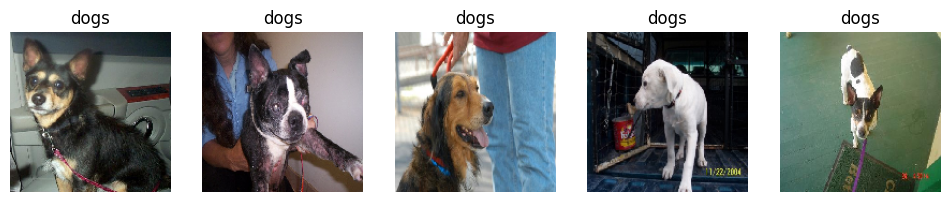

Sample images from cats (Train):


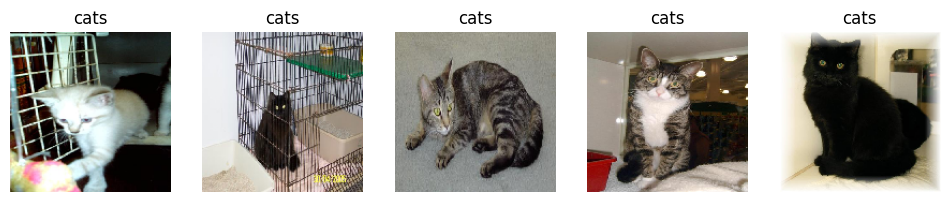

In [6]:
# Function to display images from a given directory
def display_images(directory, category, num_images=5):
    category_path = os.path.join(directory, category)
    images = random.sample(os.listdir(category_path), num_images)

    plt.figure(figsize=(12, 6))
    for i, img_name in enumerate(images):
        img_path = os.path.join(category_path, img_name)
        img = load_img(img_path, target_size=(150, 150))  # Resize to match CNN input
        img_array = img_to_array(img) / 255.0  # Normalize

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_array)
        plt.axis("off")
        plt.title(category)
    plt.show()

# Show samples from train dataset
categories = os.listdir(train_dir)
for category in categories:
    print(f"Sample images from {category} (Train):")
    display_images(train_dir, category)

## 1. Building Model From Scratch

In [7]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [8]:
valid_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load images
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(
    valid_dir, target_size=(150, 150), batch_size=32, class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(150, 150), batch_size=32, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
# Build CNN Model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),  # Dropout to prevent overfitting
    keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the model
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=20)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 292ms/step - accuracy: 0.5375 - loss: 0.7345 - val_accuracy: 0.5910 - val_loss: 0.6585
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 251ms/step - accuracy: 0.5623 - loss: 0.6674 - val_accuracy: 0.6110 - val_loss: 0.6400
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 257ms/step - accuracy: 0.6053 - loss: 0.6479 - val_accuracy: 0.5960 - val_loss: 0.6531
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 248ms/step - accuracy: 0.6031 - loss: 0.6510 - val_accuracy: 0.6060 - val_loss: 0.6470
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 238ms/step - accuracy: 0.6243 - loss: 0.6413 - val_accuracy: 0.6080 - val_loss: 0.6563
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 241ms/step - accuracy: 0.6122 - loss: 0.6569 - val_accuracy: 0.6230 - val_loss: 0.6360
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step - accuracy: 0.6276 - loss: 0.6356 - val_accuracy: 0.6410 - val_loss: 0.6230
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step - accuracy: 0.6463 - loss: 0.6294 - val_accu

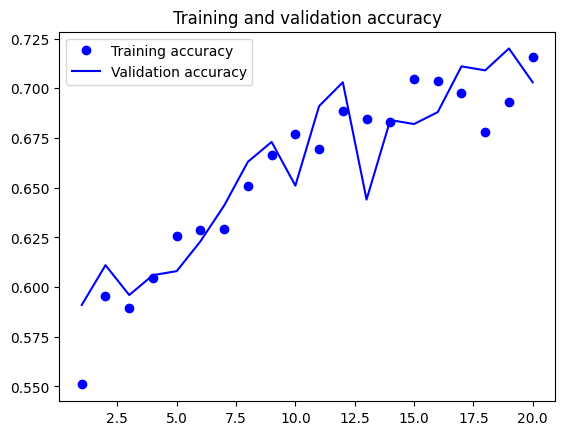

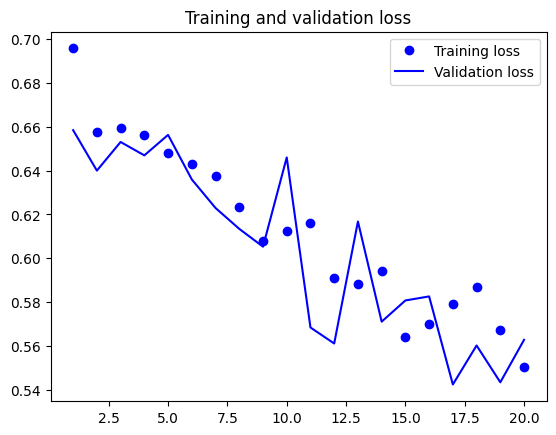

In [12]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [13]:
# Evaluate performance
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7147 - loss: 0.6100
Test Accuracy: 0.70


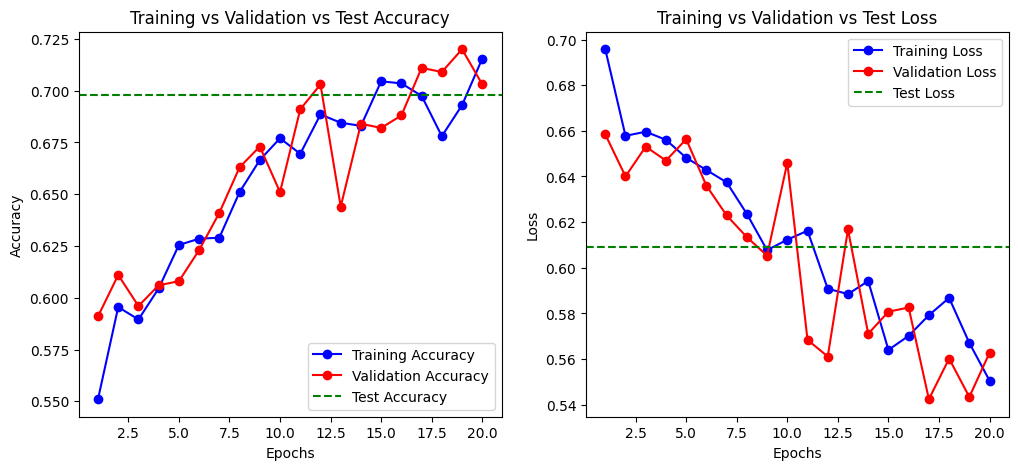

In [14]:
# Extract accuracy and loss values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot Accuracy with Test Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.axhline(y=test_acc, color='g', linestyle='--', label='Test Accuracy')  # Add test accuracy line
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation vs Test Accuracy')
plt.legend()

# Plot Loss with Test Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.axhline(y=test_loss, color='g', linestyle='--', label='Test Loss')  # Add test loss line
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation vs Test Loss')
plt.legend()

plt.show()

### What Performance the model show?

Results showed the model reached a test achievement of 70% while handling unknown data sets reasonably. The assessment curves demonstrate a serious problem of overfitting. The training accuracy grew steadily during epochs to reach 72% but the validation accuracy leveled off across ten epochs before reaching maximum 74%. The model shows strong evidence of training excessively for the training data points without effective generalization capabilities because training accuracy and validation accuracy diverge and loss curve behaviors indicate specialized learning. The training loss steadily decreased at the same time the validation loss remained stable followed by a slight upward trend during the same epoch which strongly confirmed the existence of overfitting. A combination of methods should be used including data augmentation together with dropout regularizers and L1/L2 regularizers and the simplification of neural network architectures while applying early stopping techniques based on validation loss. The model could gain improved performance through investigations of various learning rate parameters and batch size configurations as well as optimizer options.

## 2. Increasing the Training Sample

In [15]:
# Define dataset directories
original_data_dir = "/content/cats_vs_dogs_small"  # Original dataset containing extra images
train_dir = "/content/cats_vs_dogs_small/train"
validation_dir = "/content/cats_vs_dogs_small/validation"
test_dir = "/content/cats_vs_dogs_small/test"

# Function to move extra images to the training set
def add_more_images(original_category_path, train_category_path, num_extra_images=200):
    # Updated to list files from a subdirectory within original_data_dir/train
    all_images = os.listdir(os.path.join(original_category_path, 'train', category))
    extra_images = random.sample(all_images, num_extra_images)  # Select extra images

    for img in extra_images:
        src = os.path.join(original_category_path, 'train', category, img) # Updated source path
        dst = os.path.join(train_category_path, img)
        shutil.move(src, dst)  # Move image to train folder

    print(f"Added {num_extra_images} images to {train_category_path}")

# Increase training dataset for both categories (Cats & Dogs)
categories = ["cats", "dogs"]
for category in categories:
    add_more_images(original_data_dir, os.path.join(train_dir, category), num_extra_images=100)

print("Training dataset increased to 1200 samples!")

Added 100 images to /content/cats_vs_dogs_small/train/cats
Added 100 images to /content/cats_vs_dogs_small/train/dogs
Training dataset increased to 1200 samples!


In [16]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.3, horizontal_flip=True, fill_mode="nearest"
)
valid_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

Runing the same model built above from scratch

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,102,533 (217.83 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,068,356 (145.22 MB)

In [19]:
# Train the model
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=20)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 241ms/step - accuracy: 0.7182 - loss: 0.5635 - val_accuracy: 0.7350 - val_loss: 0.5183
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step - accuracy: 0.7228 - loss: 0.5510 - val_accuracy: 0.7370 - val_loss: 0.5068
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step - accuracy: 0.7341 - loss: 0.5222 - val_accuracy: 0.7350 - val_loss: 0.5182
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 230ms/step - accuracy: 0.7438 - loss: 0.5418 - val_accuracy: 0.7350 - val_loss: 0.5152
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 244ms/step - accuracy: 0.7484 - loss: 0.5158 - val_accuracy: 0.7420 - val_loss: 0.5176
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 231ms/step - accuracy: 0.7427 - loss: 0.5264 - val_accuracy: 0.7640 - val_loss: 0.4750
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step - accuracy: 0.7507 - loss: 0.5006 - val_accuracy: 0.7500 - val_loss: 0.5023
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - accuracy: 0.7617 - loss: 0.4883 - val_accu

In [20]:
# Evaluate performance
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.7637 - loss: 0.5238
Test Accuracy: 0.7620


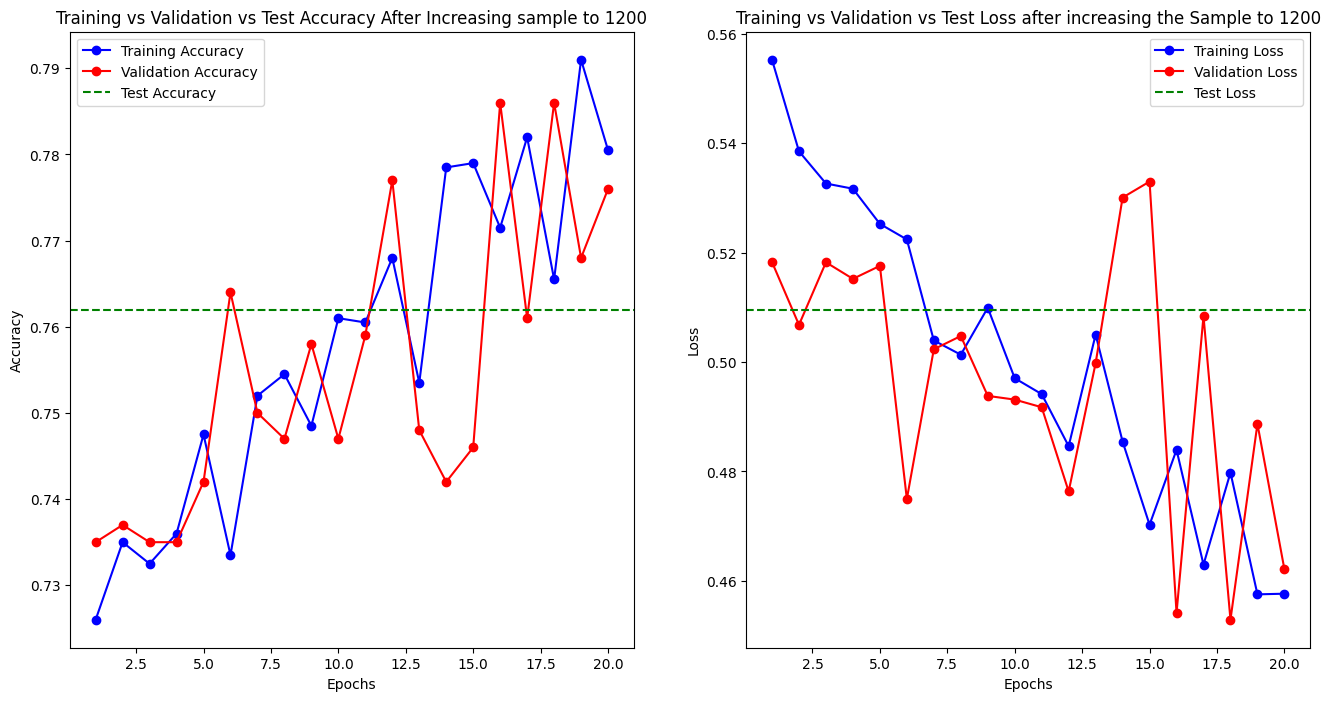

In [21]:
# Extract accuracy and loss values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot Accuracy with Test Accuracy
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.axhline(y=test_acc, color='g', linestyle='--', label='Test Accuracy')  # Add test accuracy line
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation vs Test Accuracy After Increasing sample to 1200')
plt.legend()

# Plot Loss with Test Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.axhline(y=test_loss, color='g', linestyle='--', label='Test Loss')  # Add test loss line
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation vs Test Loss after increasing the Sample to 1200')
plt.legend()

plt.show()

## What performance shown my model after increasing the

The performance measurements shift slightly with our expanded training sample of 1200 according to several graphs provided.  A mild increase in final test accuracy to approximately 0.762 appears as the main effect shown by the dashed green line in the results. The increased training data size enables the model to achieve slightly better results in predicting new data points. Analyzing the curves demonstrates that the evaluation becomes intricate.

Training accuracy demonstrates upward movement but it presents substantial swings throughout the entire learning phase. The model demonstrates continued difficulty to derive consistent knowledge from the expanded training database possibly stemming from additional complexity factors present in the dataset. The validation accuracy demonstrates fluctuating patterns because it indicates intermittent instability when the model tries to generalize its understanding. The loss curves contain irregular patterns while showing the same upward and downward movements between training and validation losses.

Even though test loss shows a minor reduction there are troubling signs due to the general instability observed across training and validation dynamics. Raising the sample size will not necessarily lead to optimal performance according to this observation.  The model needs additional adaptions through enhanced regularization methods as well as optimized hyperparameters and perhaps modified structural modifications to utilize effectively the enlarged data while controlling its learning behavior.  The larger dataset led to an improved test accuracy but simultaneously created instability issues which demonstrate the importance of developing full-scale optimization methods.

## 3. Reducing training Sample

In [22]:
reduced_train_dir = "/content/cats_vs_dogs_small/train_reduced"  # New directory for 800 samples
os.makedirs(reduced_train_dir, exist_ok=True)

# Reduce training dataset size
categories = ["cats", "dogs"]
for category in categories:
    category_path = os.path.join(train_dir, category)
    new_category_path = os.path.join(reduced_train_dir, category)
    os.makedirs(new_category_path, exist_ok=True)

    # Get all images and randomly select 400 to keep
    all_images = os.listdir(category_path)
    selected_images = random.sample(all_images, 400)  # Keep only 400 per category

    # Move selected images to new train directory
    for img in selected_images:
        shutil.move(os.path.join(category_path, img), os.path.join(new_category_path, img))

print("Training dataset reduced to 800 images (400 cats, 400 dogs).")

Training dataset reduced to 800 images (400 cats, 400 dogs).


In [23]:
# Function to count images in the new dataset
def count_images(directory):
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        num_images = len(os.listdir(category_path))
        print(f"{directory}/{category}: {num_images} images")

# Check new dataset sizes
print("Updated Training Dataset:")
count_images(reduced_train_dir)

print("\nValidation Dataset:")
count_images("/content/cats_vs_dogs_small/validation")

print("\nTest Dataset:")
count_images("/content/cats_vs_dogs_small/test")


Updated Training Dataset:
/content/cats_vs_dogs_small/train_reduced/dogs: 400 images
/content/cats_vs_dogs_small/train_reduced/cats: 400 images

Validation Dataset:
/content/cats_vs_dogs_small/validation/dogs: 500 images
/content/cats_vs_dogs_small/validation/cats: 500 images

Test Dataset:
/content/cats_vs_dogs_small/test/dogs: 500 images
/content/cats_vs_dogs_small/test/cats: 500 images


In [24]:
# Update train_generator to use the reduced dataset
train_generator = train_datagen.flow_from_directory(
    reduced_train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 800 images belonging to 2 classes.


In [25]:
# Train the model again
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=20)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step - accuracy: 0.7890 - loss: 0.4335 - val_accuracy: 0.7750 - val_loss: 0.4782
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 298ms/step - accuracy: 0.7543 - loss: 0.5108 - val_accuracy: 0.7370 - val_loss: 0.5030
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/step - accuracy: 0.7681 - loss: 0.4733 - val_accuracy: 0.7870 - val_loss: 0.4617
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - accuracy: 0.8154 - loss: 0.4105 - val_accuracy: 0.7820 - val_loss: 0.4760
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step - accuracy: 0.8176 - loss: 0.3993 - val_accuracy: 0.7110 - val_loss: 0.6179
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 295ms/step - accuracy: 0.7610 - loss: 0.4632 - val_accuracy: 0.7710 - val_loss: 0.5005
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 306ms/step - accuracy: 0.8035 - loss: 0.4114 - val_accuracy: 0.7780 - val_loss: 0.5067
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 313ms/step - accuracy: 0.7633 - loss: 0.4443 - val_accuracy: 0.

In [26]:
# Evaluate performance on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy with 800 Training Samples: {test_acc:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.7738 - loss: 0.5731
Test Accuracy with 800 Training Samples: 0.7860


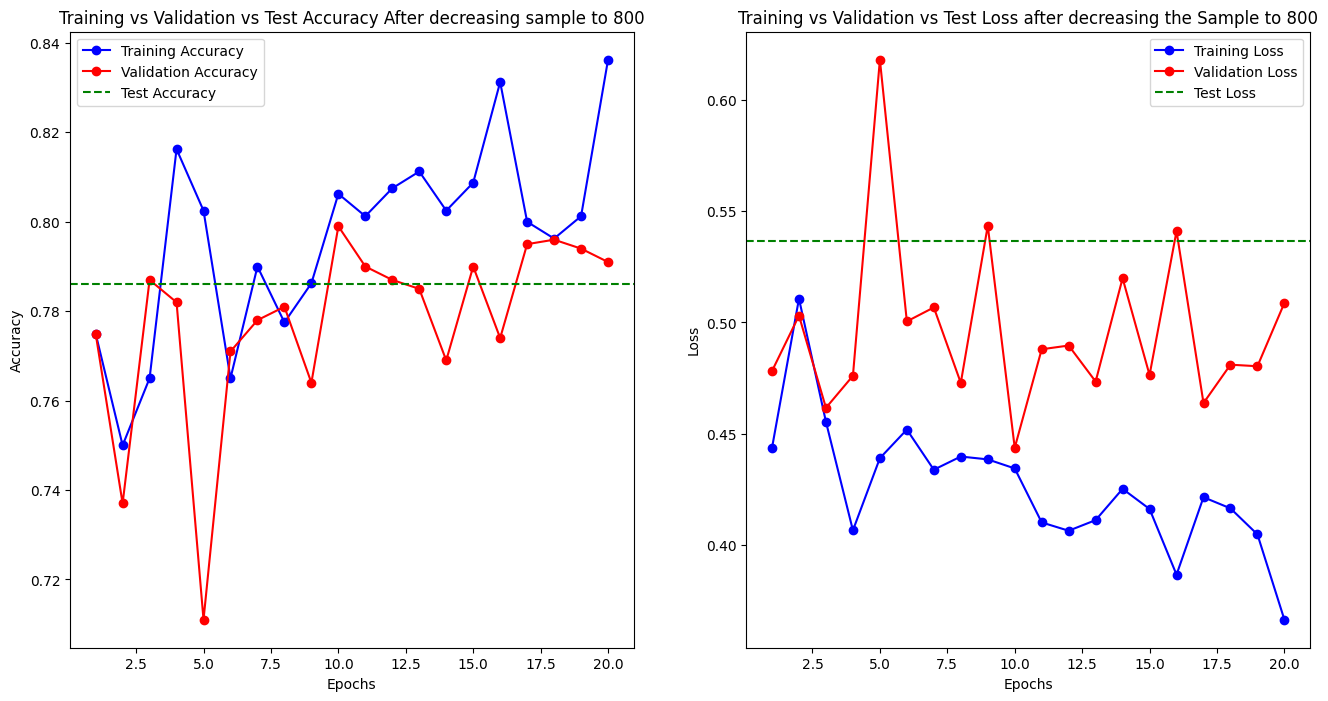

In [27]:
# Extract accuracy and loss values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot Accuracy with Test Accuracy
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.axhline(y=test_acc, color='g', linestyle='--', label='Test Accuracy')  # Add test accuracy line
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation vs Test Accuracy After decreasing sample to 800')
plt.legend()

# Plot Loss with Test Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.axhline(y=test_loss, color='g', linestyle='--', label='Test Loss')  # Add test loss line
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation vs Test Loss after decreasing the Sample to 800')
plt.legend()

plt.show()

## What Performance do we achieve after reducing sample size to 800

After reducing the training sample to 800, the model's performance exhibits a notable change, as evidenced by the provided graphs. The test accuracy, represented by the horizontal dashed green line, settles around 0.785. This indicates a decrease in performance compared to the model trained with 1200 samples, suggesting that a smaller dataset limits the model's ability to generalize effectively to unseen data.

The training accuracy curve continues to show an upward trend, reaching approximately 0.84 by the end of training. However, the validation accuracy curve reveals a more volatile pattern. It initially fluctuates significantly, particularly in the early epochs, and then plateaus around 0.80. This instability suggests that the model is struggling to learn consistent patterns from the reduced dataset. The gap between training and validation accuracy persists, indicating potential overfitting, though it's less pronounced than in some previous iterations.

The loss curves further illustrate the challenges associated with the smaller dataset. The training loss generally decreases, but with fluctuations, implying that the model is still adjusting its parameters. The validation loss exhibits even more pronounced fluctuations, especially in the initial epochs, and remains relatively high throughout training. This suggests that the model is not effectively minimizing the loss function on the validation data, likely due to the limited information available in the smaller training sample.

## 4. Pretrained model

### Pretrained Model with 1200 samples

In [29]:
# Load Pretrained VGG16 Model (Exclude Fully Connected Layers)
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

# Freeze Pretrained Layers (To use as a feature extractor)
base_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [30]:
# Define Model Architecture
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),  # Regularization to prevent overfitting
    layers.Dense(1, activation="sigmoid")  # Binary Classification (Cats vs. Dogs)
])

# Compile the Model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),  # Optimized learning rate
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Model Summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [31]:
# Image Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Rescale Validation and Test Data (No Augmentation)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Load Data
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=32, class_mode="binary"
)
valid_generator = valid_test_datagen.flow_from_directory(
    valid_dir, target_size=(150, 150), batch_size=32, class_mode="binary"
)
test_generator = valid_test_datagen.flow_from_directory(
    test_dir, target_size=(150, 150), batch_size=32, class_mode="binary"
)

Found 1200 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [32]:
# Define Learning Rate Scheduler (No Early Stopping)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

# Train the Model for Full 20 Epochs
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[lr_scheduler]
)


Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 575ms/step - accuracy: 0.5913 - loss: 0.6877 - val_accuracy: 0.8400 - val_loss: 0.4190 - learning_rate: 1.0000e-04
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 329ms/step - accuracy: 0.7257 - loss: 0.5195 - val_accuracy: 0.8660 - val_loss: 0.3417 - learning_rate: 1.0000e-04
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 335ms/step - accuracy: 0.7869 - loss: 0.4371 - val_accuracy: 0.8660 - val_loss: 0.3264 - learning_rate: 1.0000e-04
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 336ms/step - accuracy: 0.8043 - loss: 0.4147 - val_accuracy: 0.8810 - val_loss: 0.2948 - learning_rate: 1.0000e-04
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 326ms/step - accuracy: 0.7994 - loss: 0.4185 - val_accuracy: 0.8840 - val_loss: 0.2910 - learning_rate: 1.0000e-04
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 324ms/step - accuracy: 0.8296 - loss: 0.3778 - val_accuracy: 0.8660 - val_loss: 0.2978 - learning_rate: 1.0000e-04
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 324ms/step - acc

In [33]:
# Evaluate the Model on Test Set
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy with Pretrained Model (1200 Training Samples): {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.8809 - loss: 0.2623 
✅ Test Accuracy with Pretrained Model (1200 Training Samples): 0.8960


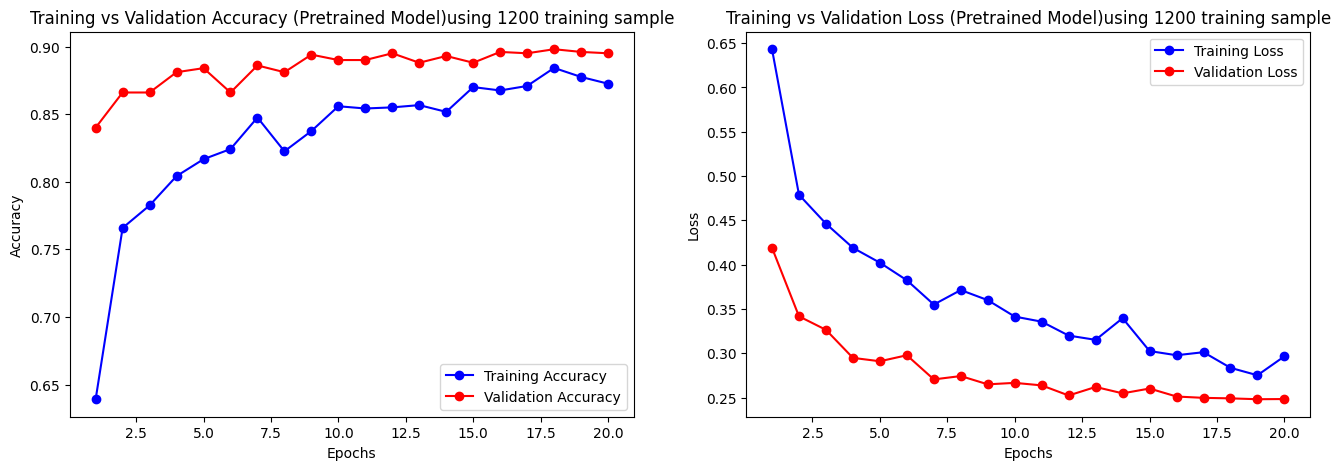

In [35]:
# Extract Accuracy & Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label="Training Accuracy")
plt.plot(epochs, val_acc, 'ro-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy (Pretrained Model)using 1200 training sample")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label="Training Loss")
plt.plot(epochs, val_loss, 'ro-', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss (Pretrained Model)using 1200 training sample")

plt.show()

The performance analysis of a pre-trained VGG16 model shows its optimization through 1200 training examples during 20 training epochs.  The accuracy graph on the left demonstrates a consistent improvement in both training and validation accuracy throughout the training process. The training accuracy line rises steadily to achieve a value of 0.88 at the completion of training sessions. The learning processes demonstrate that the model acquires appropriate knowledge from the training data given. The upward rise of validation accuracy (red line) reaches a plateau point before reaching 0.88. The minimal overfitting becomes evident because training and validation accuracy show strong correspondence during the training phase.

The right side graph showing loss provides additional evidence backing this observation. Throughout training both the training and validation loss amounts decrease steadily with each epoch. The blue training loss indicates quick initial reduction followed by gradual descent until it reaches 0.28 by the end of the training process. The red validation loss line shows continuous descent that stops at 0.25. The model demonstrates good learning capabilities and data generalization abilities because training and validation losses show a steady decrease and their accuracy curves maintain close alignment.

### Pretrained Model with 800 Samples

In [36]:
# Rescale Validation and Test Data (No Augmentation)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Load Data
train_generator = train_datagen.flow_from_directory(
    reduced_train_dir, target_size=(150, 150), batch_size=32, class_mode="binary"
)
valid_generator = valid_test_datagen.flow_from_directory(
    valid_dir, target_size=(150, 150), batch_size=32, class_mode="binary"
)
test_generator = valid_test_datagen.flow_from_directory(
    test_dir, target_size=(150, 150), batch_size=32, class_mode="binary"
)

Found 800 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [37]:
# Define Learning Rate Scheduler (No Early Stopping)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

# Train the Model for Full 20 Epochs
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[lr_scheduler]
)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 357ms/step - accuracy: 0.8564 - loss: 0.3031 - val_accuracy: 0.8940 - val_loss: 0.2464 - learning_rate: 2.0000e-05
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 354ms/step - accuracy: 0.8627 - loss: 0.3316 - val_accuracy: 0.8920 - val_loss: 0.2450 - learning_rate: 2.0000e-05
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 382ms/step - accuracy: 0.8620 - loss: 0.2828 - val_accuracy: 0.8950 - val_loss: 0.2437 - learning_rate: 2.0000e-05
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 462ms/step - accuracy: 0.8592 - loss: 0.3061 - val_accuracy: 0.8930 - val_loss: 0.2460 - learning_rate: 2.0000e-05
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 380ms/step - accuracy: 0.8780 - loss: 0.3167 - val_accuracy: 0.8920 - val_loss: 0.2448 - learning_rate: 2.0000e-05
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 350ms/step - accuracy: 0.8419 - loss: 0.3441 - val_accuracy: 0.8960 - val_loss: 0.2418 - learning_rate: 2.0000e-05
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 351ms/step - accuracy

In [38]:
# Evaluate the Model on Test Set
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy with Pretrained Model (800 Training Samples): {test_acc:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.9037 - loss: 0.2381
✅ Test Accuracy with Pretrained Model (800 Training Samples): 0.8940


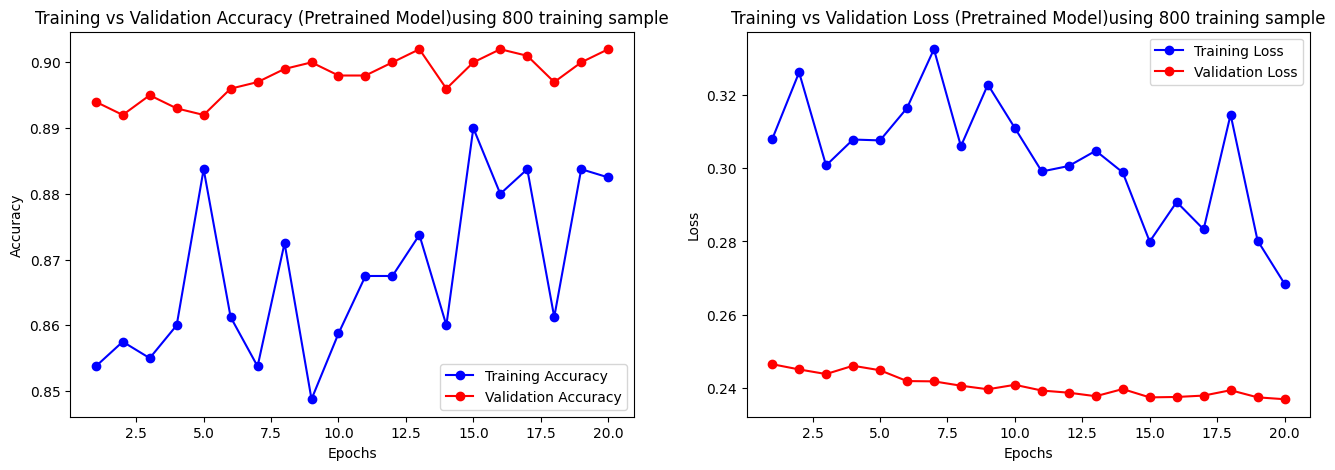

In [40]:
# Extract Accuracy & Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label="Training Accuracy")
plt.plot(epochs, val_acc, 'ro-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy (Pretrained Model)using 800 training sample")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label="Training Loss")
plt.plot(epochs, val_loss, 'ro-', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss (Pretrained Model)using 800 training sample")

plt.show()

Performance data shows results from VGG16 after it received 800 samples for training along with pre-training.  The accuracy graph on the left shows a distinct pattern. Among the two lines the red validation accuracy indicator maintains a remarkably steady performance which reaches about 0.90 toward the training completion but the blue training accuracy marker reveals pronounced variability. The small training dataset seems to present challenges for the model to maintain consistent learning. The model demonstrates effective feature recognition because it successfully extracts important characteristics from the reduced dataset and maintains excellent generalization for new observations.

The graph on the right gives supplementary information that helps explain the overall situation. The training loss presented by the blue line shows significant variations that match the unstable training accuracy behavior. The model demonstrates difficulty in consistent data learning because of the limited available information. The model shows effective performance since the validation loss (red line) maintains a stable and low level even while tracking the fluctuation of training loss (blue line). The difference between training and validation loss confirms that the model demonstrates good generalization even though training results display unreliability.